# OVERVIEW
In this project, we developed an autoencoder model to perform dimensionality reduction, transforming image data from a size of 784 (28x28 pixels) down to a latent representation of 128 dimensions. The quality of the images reconstructed by the decoder was evaluated using the Structural Similarity Index (SSIM) on the test dataset. Two distinct models were created, and hyperparameter tuning was conducted to optimize performance. The selection of the best model was based on the evaluation results obtained from the SSIM scores.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Dense
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

import warnings
warnings.filterwarnings('ignore')

import random
SEED_VALUE = 100
np.random.seed(SEED_VALUE)            # For NumPy
random.seed(SEED_VALUE)               # For Python's random module

# Data Loading

The dataset used is Fashion MNIST, which is stored in `keras.dataset.fashion_mnist`.

In [ ]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = fashion_mnist.load_data()

In [ ]:
x = np.concatenate((x_train_raw, x_test_raw))
y = np.concatenate((y_train_raw, y_test_raw))

In [ ]:
value_counts = np.bincount(y)

for label, count in enumerate(value_counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 7000 occurrences
Label 1: 7000 occurrences
Label 2: 7000 occurrences
Label 3: 7000 occurrences
Label 4: 7000 occurrences
Label 5: 7000 occurrences
Label 6: 7000 occurrences
Label 7: 7000 occurrences
Label 8: 7000 occurrences
Label 9: 7000 occurrences


Each label has 7,000 image data.


In [ ]:
print(x.shape)
print(y.shape)

(70000, 28, 28)
(70000,)


It can be seen that the total dataset consists of 70,000 images, each with a size of 28x28 pixels.

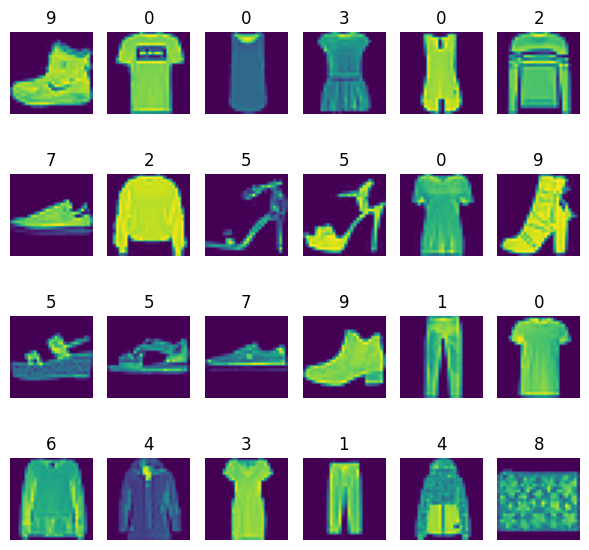

In [ ]:
def plot_examples(data, labels, num_examples):
    plt.figure(figsize=(6, 6))
    for i in range(num_examples):
        plt.subplot(4, 6, i+1)
        plt.imshow(data[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_examples(x, y, 24)

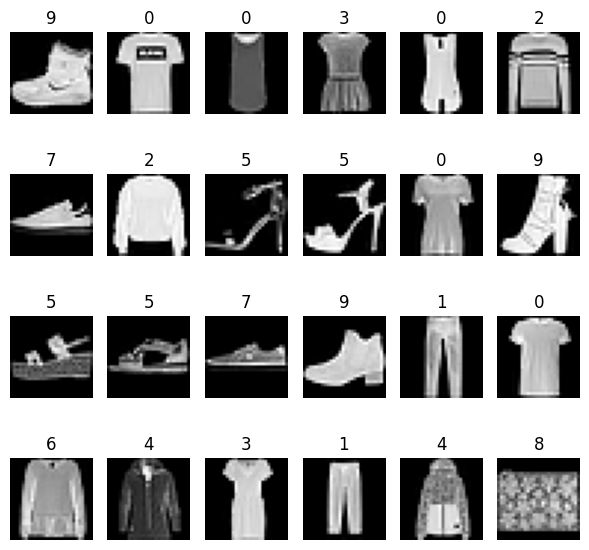

In [ ]:
def plot_examples(data, labels, num_examples):
    plt.figure(figsize=(6, 6))
    for i in range(num_examples):
        plt.subplot(4, 6, i+1)
        plt.imshow(data[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_examples(x, y, 24)

The image above is the greyscale version of the data being used. These are the types of images that will be used in the training process.

In [ ]:
x.shape[1:3]

(28, 28)

The images have a size of 28x28 pixels.

In [ ]:
x = x.astype('float32') / 255.0
x = np.expand_dims(x, -1)


In the code above, I performed scaling and added a dimension for the image channel. Since the training images are in grayscale format, an additional channel dimension needs to be added.

# Split Dataset

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print("Train shape", x_train.shape, y_train.shape)
print("Val shape:", x_val.shape, y_val.shape)
print("Test shape:", x_test.shape, y_test.shape)

Train shape (56000, 28, 28, 1) (56000,)
Val shape: (7000, 28, 28, 1) (7000,)
Test shape: (7000, 28, 28, 1) (7000,)


Here, I split the dataset into 80% for training, 10% for validation, and 10% for testing. The training data consists of 56,000 images, while the validation and test sets each contain 7,000 images.

# Modeling

## 1. Baseline Model

The baseline autoencoder model architecture I designed consists of an encoder and a decoder, specifically tailored to process images of size 28x28 pixels with a single channel. The encoder starts with an input layer followed by two Conv2D layers with 32 filters, a 3x3 kernel size, and ReLU activation. This is followed by a MaxPooling2D layer for downsampling, then the output is flattened and passed through a Dense layer with a latent dimension of 128.

The decoder takes the latent vector and passes it through a Dense layer with 6,272 units, which is then reshaped into a 14x14x32 size. Next, an UpSampling2D layer is used for upsampling, followed by two Conv2D layers with 32 filters and a 3x3 kernel, and ending with an output Conv2D layer with one filter and sigmoid activation to reconstruct the image. The model is compiled using the Adam optimizer and MSE loss.

During training, I also employed early stopping to prevent overfitting.

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from skimage.metrics import structural_similarity as ssim

In [ ]:
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)  # Filter 3x3 px
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    latent = Dense(latent_dim, activation='relu')(x)
    return Model(inputs, latent, name='encoder')

def build_decoder(latent_dim):
    decoder_inputs = Input(shape=(latent_dim,))
    x = Dense(6272, activation='relu')(decoder_inputs)
    x = Reshape((14, 14, 32))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(decoder_inputs, outputs, name='decoder')

def build_autoencoder(input_shape, latent_dim):
    encoder = build_encoder(input_shape, latent_dim)
    decoder = build_decoder(latent_dim)
    inputs = Input(shape=input_shape)
    autoencoder_outputs = decoder(encoder(inputs))
    return Model(inputs, autoencoder_outputs, name='autoencoder')

In [ ]:
latent_dim = 128
input_shape = (28, 28, 1)
model_baseline = build_autoencoder(input_shape, latent_dim)
model_baseline.compile(optimizer=Adam(), loss=MeanSquaredError())

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [ ]:
history_baseline = model_baseline.fit(x_train, x_train, epochs=100, batch_size=128, shuffle=True,
                                      validation_data=(x_val, x_val),callbacks=[early_stopping])

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0420 - val_loss: 0.0113
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0103 - val_loss: 0.0083
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 12/100
438/438 ━━━━━━━━━━━━━━━━━━━

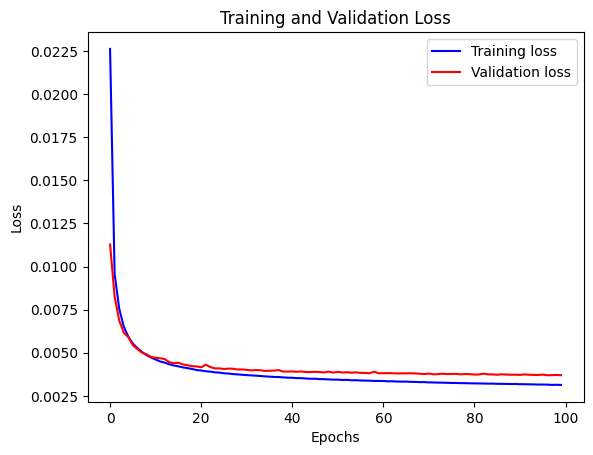

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history_baseline, "Training and Validation Loss")

Based on the plot above, it can be seen that the model's performance is quite good and shows a good fit, as there is only a very small gap between the training loss and validation loss.

In [ ]:
def evaluate_ssim(originals, reconstructions):
    ssim_scores = []
    for i in range(len(originals)):
        score = ssim(originals[i], reconstructions[i], win_size=None, channel_axis=-1, data_range=1.0)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

reconstructions_baseline = model_baseline.predict(x_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
ssim_score = evaluate_ssim(x_test, reconstructions_baseline)
print(f'Average SSIM Score on Test Set: {ssim_score:.4f}')

Average SSIM Score on Test Set: 0.8991


Based on the SSIM evaluation using the test data, a score of 89.91% was obtained. The score is close to 90%, which means the reconstructed images have a quality that is quite good and almost identical to the original images.

## 2. Modified Model

To achieve optimal Dimension Reduction representation, I modified the autoencoder architecture.

I added convolutional layers and convolutional transpose layers in the encoder-decoder architecture, which allows the model to better capture spatial structures and image details.

The modified autoencoder architecture consists of an encoder and a decoder, each designed to process 28x28 pixel images with a single channel. The encoder has three Conv2D layers with 32, 64, and 128 filters, followed by a Flatten layer and Dense layer to produce a latent representation of dimension 128. The decoder transforms the latent vector back into image form using a Dense layer, Reshape layer, and three Conv2DTranspose layers with 128, 64, and 1 filters, ending with a sigmoid activation. The model is compiled with the Adam optimizer and MeanSquaredError loss to minimize the difference between the original and reconstructed images.

Evaluation results with test data from this new model show a slight improvement compared to the baseline model. Thus, it can be concluded that this modified model is slightly better and more optimal in achieving Dimension Reduction representation.

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, Dropout, Conv2DTranspose

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

def encoder_modif(input_shape, latent_dim):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Flatten()(x)
    outputs = Dense(latent_dim, activation='relu')(x)
    return Model(inputs, outputs, name='encoder')

def decoder_modif(latent_dim):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(7*7*128, activation='relu')(latent_inputs)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, outputs, name='decoder')

def autoencoder_modif(input_shape, latent_dim):
    encoder = encoder_modif(input_shape, latent_dim)
    decoder = decoder_modif(latent_dim)
    inputs = Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    return Model(inputs, decoded, name='autoencoder')

In [ ]:
latent_dim = 128
input_shape = (28, 28, 1)
model_modif1 = autoencoder_modif(input_shape, latent_dim)
model_modif1.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [ ]:
history_modif1 = model_modif1.fit(x_train, x_train, epochs=100, batch_size=128, shuffle=True,
                                validation_data=(x_val, x_val), callbacks=[early_stopping])

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - loss: 0.0463 - val_loss: 0.0118
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0106 - val_loss: 0.0084
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0080 - val_loss: 0.0069
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 12/100
438/438 ━━━━

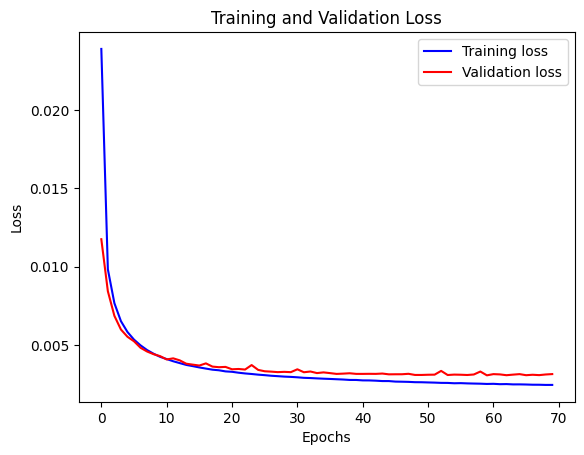

In [ ]:
visualize_loss(history_modif1, "Training and Validation Loss")

Based on the plot above, it can be seen that the model's performance is already good and shows a good fit. The gap between the training loss and validation loss is very small.

In [ ]:
reconstructions_modif1 = model_modif1.predict(x_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [ ]:
ssim_score1 = evaluate_ssim(x_test, reconstructions_modif1)
print(f'Average SSIM Score on Test Set: {ssim_score1:.4f}')

Average SSIM Score on Test Set: 0.9180


It can be observed that there is an improvement in the SSIM score of this modified model compared to the baseline model, with an increase of nearly 2%. Therefore, I will use this architecture to perform hyperparameter tuning to find the most optimal hyperparameters.

## Hyperparameter Tuning

I manually performed hyperparameter tuning for the learning rate `[0.001, 0.0001]` and latent dimension `[64, 128]`. As a result, I created 4 combinations for hyperparameter tuning:

- **Learning rate = 0.001 and latent dimension = 128** (model_modif1, this model was already created above)
- **Learning rate = 0.0001 and latent dimension = 128** (model_modif2)
- **Learning rate = 0.001 and latent dimension = 64** (model_modif3)
- **Learning rate = 0.0001 and latent dimension = 64** (model_modif4)

### Modification 2 => learning rate = 0.0001, latent_dim = 128

In [ ]:
latent_dim = 128
input_shape = (28, 28, 1)
model_modif2 = autoencoder_modif(input_shape, latent_dim)
model_modif2.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [ ]:
history_modif2 = model_modif2.fit(x_train, x_train, epochs=100, batch_size=128,
                                validation_data=(x_val, x_val), callbacks=[early_stopping])

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0940 - val_loss: 0.0191
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0177 - val_loss: 0.0154
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0149 - val_loss: 0.0137
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0135 - val_loss: 0.0126
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0124 - val_loss: 0.0117
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 12/100
438/438 ━━━━

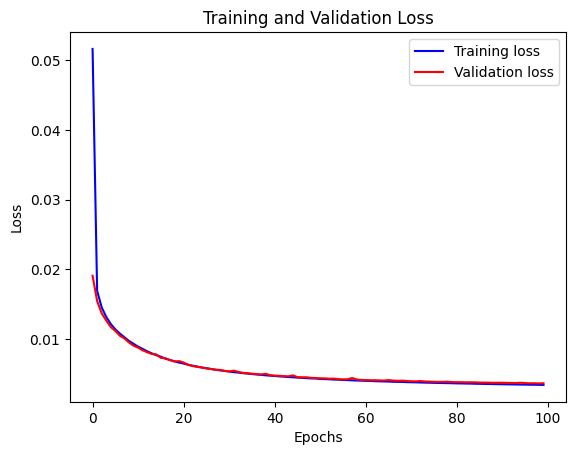

In [ ]:
visualize_loss(history_modif2, "Training and Validation Loss")

Just like the previous models, this model also shows a good fit, as there is no significant gap between the training loss and validation loss.

In [ ]:
reconstructions2 = model_modif2.predict(x_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
ssim2 = evaluate_ssim(x_test, reconstructions2)
print(f'Average SSIM Score on Test Set: {ssim2:.4f}')

Average SSIM Score on Test Set: 0.9038


### Modification 3 => learning rate = 0.001, latent_dim = 64

In [ ]:
latent_dim = 64
input_shape = (28, 28, 1)
model_modif3 = autoencoder_modif(input_shape, latent_dim)
model_modif3.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [ ]:
history_modif3 = model_modif3.fit(x_train, x_train, epochs=100, batch_size=128,
                                validation_data=(x_val, x_val), callbacks=[early_stopping])

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.0499 - val_loss: 0.0122
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0111 - val_loss: 0.0088
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0074 - val_loss: 0.0068
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 12/100
438/438 ━━━

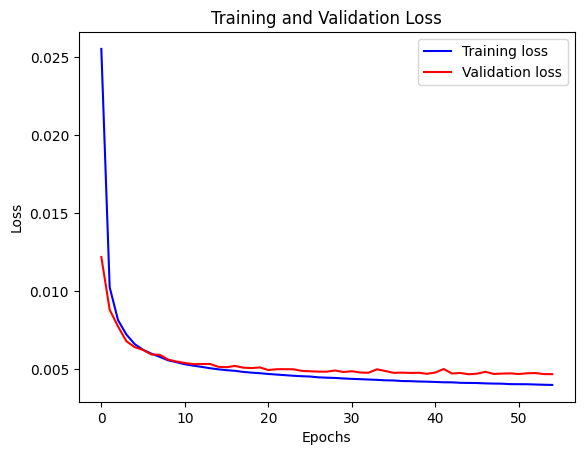

In [ ]:
visualize_loss(history_modif3, "Training and Validation Loss")

Looking at the plot above, this model shows a good fit, as there is no significant gap between the training loss and validation loss.

In [ ]:
reconstructions3 = model_modif3.predict(x_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
ssim3 = evaluate_ssim(x_test, reconstructions3)
print(f'Average SSIM Score on Test Set: {ssim3:.4f}')

Average SSIM Score on Test Set: 0.8737


### Modification 4 =>learning rate = 0.0001, latent_dim = 64

In [ ]:
latent_dim = 64
input_shape = (28, 28, 1)
model_modif4 = autoencoder_modif(input_shape, latent_dim)
model_modif4.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [ ]:
history_modif4 = model_modif4.fit(x_train, x_train, epochs=100, batch_size=128,
                                validation_data=(x_val, x_val), callbacks=[early_stopping])

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.0994 - val_loss: 0.0206
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0193 - val_loss: 0.0167
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0145 - val_loss: 0.0137
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0134 - val_loss: 0.0127
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 12/100
438/438 ━━━

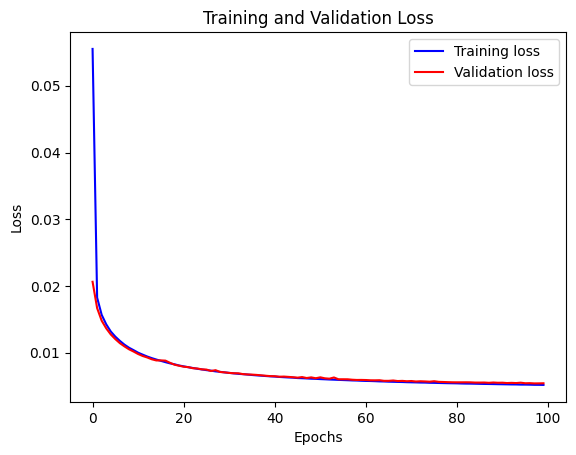

In [ ]:
visualize_loss(history_modif4, "Training and Validation Loss")

Looking at the plot above, this model is similar to model_modif2 and also shows a good fit, as there is no significant gap between the training loss and validation loss.

In [ ]:
reconstructions4 = model_modif4.predict(x_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
ssim4 = evaluate_ssim(x_test, reconstructions4)
print(f'Average SSIM Score on Test Set: {ssim4:.4f}')

Average SSIM Score on Test Set: 0.8585


# Evaluation & Conclusion

In this project, two autoencoder models were developed for dimensionality reduction of 28x28 pixel images across 10 classes: a baseline model and a modified model with manual tuning.

## Model Architecture

1. **Baseline Autoencoder**:
   - The baseline architecture consists of an encoder and a decoder designed to process single-channel images of size 28x28 pixels.
   - **Encoder**: 
     - Input layer
     - Two Conv2D layers with 32 filters, 3x3 kernel size, and ReLU activation
     - MaxPooling2D layer for downsampling
     - Flatten layer followed by a Dense layer with a latent dimension of 128
   - **Decoder**: 
     - Dense layer with 6,272 units (corresponding to the flattened output)
     - Reshaping into a 14x14x32 size
     - UpSampling2D layer followed by two Conv2D layers with 32 filters and a final Conv2D layer with one filter and sigmoid activation to reconstruct the image.
   - Compiled using the Adam optimizer and Mean Squared Error (MSE) loss. Early stopping was employed to prevent overfitting.

2. **Modified Autoencoder**:
   - The modified architecture enhances the baseline model by incorporating additional convolutional layers and convolutional transpose layers, improving the model's capacity to capture spatial structures and image details.
   - **Encoder**:
     - Input layer
     - Three Conv2D layers with 32, 64, and 128 filters
     - Flatten layer followed by a Dense layer to produce a latent representation of dimension 128
   - **Decoder**:
     - Transforms the latent vector back into image form using a Dense layer, a Reshape layer, and three Conv2DTranspose layers with 128, 64, and 1 filters, ending with a sigmoid activation.
   - Compiled with the Adam optimizer and Mean Squared Error loss to minimize the difference between the original and reconstructed images.

## Evaluation Results

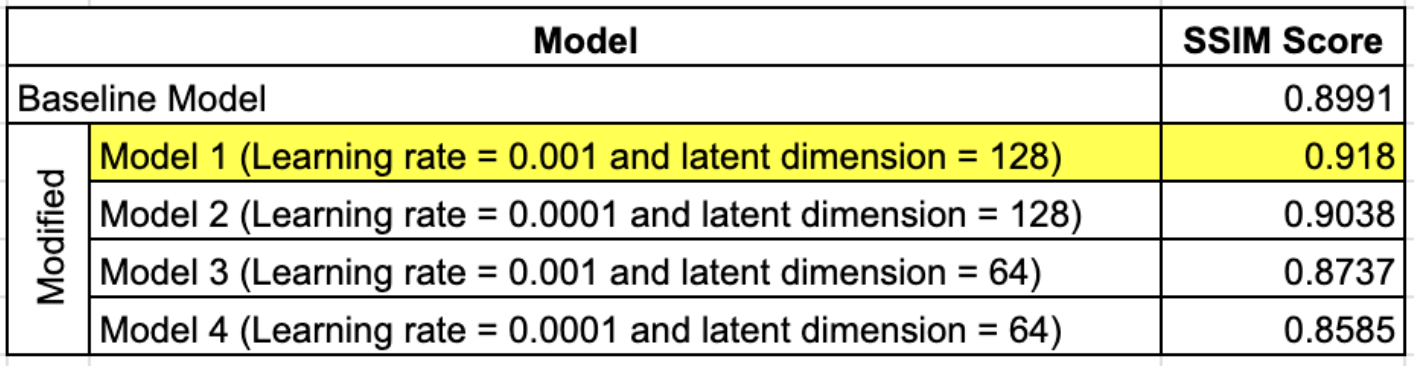

The evaluation of the two models using SSIM (Structural Similarity Index) demonstrated notable improvements:

- **Baseline Model**: SSIM score of **0.8991**
- **Modified Model**: SSIM score of **0.9180**

This indicates that the modified model provides better image reconstruction quality, closely resembling the original images.

## Conclusion

The modifications made to the autoencoder architecture, particularly the addition of more convolutional layers, resulted in improved performance over the baseline model. The modified autoencoder achieved a higher SSIM score, confirming its capability to produce more accurate dimensionality reduction representations.

In summary, the modified autoencoder is slightly better and more optimal for achieving dimensionality reduction compared to the baseline model. Future work may involve further hyperparameter tuning and exploring alternative architectures to enhance the performance even more.